<a href="https://colab.research.google.com/github/nomomon/NLP-course-project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-Levenshtein

In [23]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.layers import Embedding, LSTM, Dense

from Levenshtein import distance as lev

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

## Load data

In [ ]:
!curl http://www.manythings.org/anki/deu-eng.zip -o deu-eng.zip
!unzip deu-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9592k  100 9592k    0     0  1900k      0  0:00:05  0:00:05 --:--:-- 2392k:05 --:--:-- 1901k
Archive:  deu-eng.zip
replace deu.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [24]:
df = pd.read_csv("deu.txt", sep="\t", header=None)
df.columns=["eng", "ger", "attr"]
df.drop(columns=["attr"], inplace=True)
df.head()

,eng,ger
0,Go.,Geh.
1,Hi.,Hallo!
2,Hi.,Grüß Gott!
3,Run!,Lauf!
4,Run.,Lauf!


## Preprocess data

In [25]:
def prep(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-ZäöüÄÖÜß?.!,¿]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

print(prep("Hello, how are you?"))
print(prep("I am fine, thank you."))

# test in german (umlaut)
print(prep("Hallo, wie geht es dir?"))
print(prep("Mir geht es gut, danke."))
print(prep("Bäcker können sehr viele verschiedene Sorten Brot machen, auch süßes Gebäck"))

hello , how are you ?
i am fine , thank you .
hallo , wie geht es dir ?
mir geht es gut , danke .
bäcker können sehr viele verschiedene sorten brot machen , auch süßes gebäck


In [26]:
df["eng"] = df["eng"].apply(prep)
df["ger"] = df["ger"].apply(prep)

print(df.shape)
df.head()

(261499, 2)


,eng,ger
0,go .,geh .
1,hi .,hallo !
2,hi .,grüß gott !
3,run !,lauf !
4,run .,lauf !


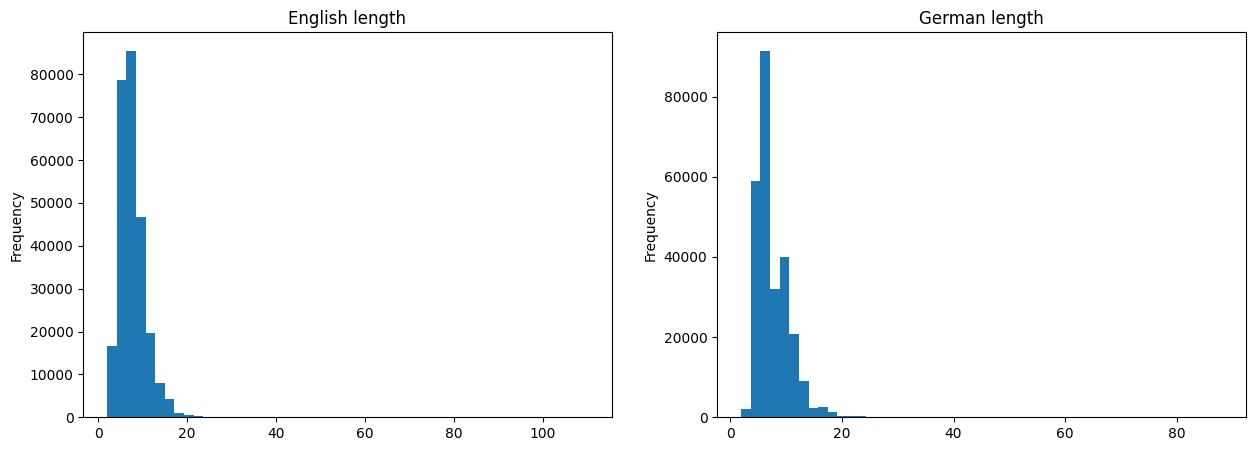

In [27]:
# visualize sentence lengths
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

df["eng"].apply(lambda x: len(x.split(" "))).plot(kind="hist", bins=50, ax=axs[0], title="English length")
df["ger"].apply(lambda x: len(x.split(" "))).plot(kind="hist", bins=50, ax=axs[1], title="German length")
plt.show()

In [28]:
eng_max_len = 20
ger_max_len = 20

df = df[df["eng"].apply(lambda x: len(x.split(" "))) <= eng_max_len]
df = df[df["ger"].apply(lambda x: len(x.split(" "))) <= ger_max_len]

df.shape

(260372, 2)

## German Tokenization and Embedding

In [ ]:
!curl -O https://int-emb-glove-de-wiki.s3.eu-central-1.amazonaws.com/vectors.txt -o vectors.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3571M  100 3571M    0     0  13.3M      0  0:04:28  0:04:28 --:--:-- 13.4M


In [30]:
# load the glove embeddings
ger_embeddings_index = {}
with open("vectors.txt", encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        ger_embeddings_index[word] = coefs

print("Found %s word vectors." % len(ger_embeddings_index))

1309281it [01:42, 12739.23it/s]

Found 1309281 word vectors.


In [31]:
ger_max_len += 2

# add the start and end tokens
df["ger"] = df["ger"].apply(lambda x: "<sos> " + x + " <eos>")

In [33]:
# make german tokenizer
ger_tokenizer = Tokenizer(filters="", oov_token="<unk>")
ger_tokenizer.fit_on_texts(df["ger"].values)

# if the word is not in the embeddings, mark it as <unk>
for word in ger_tokenizer.word_index:
    if word not in ger_embeddings_index:
        ger_tokenizer.word_index[word] = 1 # <unk> token

# add padding and start/end tokens
ger_tokenizer.word_index["<pad>"] = 0
ger_tokenizer.index_word[0] = "<pad>"
ger_vocab_size = len(ger_tokenizer.word_index)

ger_vocab_size

36883

In [34]:
target = ger_tokenizer.texts_to_sequences(df["ger"].values)

# padd sequences to max length
target = pad_sequences(target, padding="post", maxlen=ger_max_len)

target

array([[    1,   591,     1, ...,     0,     0,     0],
       [    1,  1760,     1, ...,     0,     0,     0],
       [    1,  4511,  1497, ...,     0,     0,     0],
       ...,
       [    1,    20,    35, ...,     1,     1,     0],
       [    1,    11,     1, ...,     0,     0,     0],
       [    1, 14915, 36879, ..., 15318,     1,     1]], dtype=int32)

In [35]:
# make the embedding matrix
ger_embedding_dim = 300
ger_embedding_matrix = np.zeros((ger_vocab_size, ger_embedding_dim))
for word, i in tqdm(ger_tokenizer.word_index.items()):
    embedding_vector = ger_embeddings_index.get(word)
    if embedding_vector is not None:
        ger_embedding_matrix[i] = embedding_vector

ger_embedding_matrix.shape

100%|██████████| 36883/36883 [00:00<00:00, 275375.49it/s]


(36883, 300)

## English Tokenization and Embedding

In [ ]:
!curl https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip -o glove.6B.zip
!unzip -q glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0  822M    0  111k    0     0  74820      0  3:12:03  0:00:01  3:12:02 74933^C
[glove.6B.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of glove.6B.zip or
        glove.6B.zip.zip, and cannot find glove.6B.zip.ZIP, period.


In [36]:
# load the glove embeddings
eng_embeddings_index = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        eng_embeddings_index[word] = coefs

print("Found %s word vectors." % len(eng_embeddings_index))

400000it [00:10, 38178.62it/s]

Found 400000 word vectors.


In [37]:
# make english tokenizer
eng_tokenizer = Tokenizer(filters="", oov_token="<unk>")
eng_tokenizer.fit_on_texts(df["eng"].values)

# if the word is not in the embeddings, mark it as <unk>
for word in eng_tokenizer.word_index:
    if word not in eng_embeddings_index:
        eng_tokenizer.word_index[word] = 1 # <unk> token

# add padding
eng_tokenizer.word_index["<pad>"] = 0
eng_tokenizer.index_word[0] = "<pad>"
eng_vocab_size = len(eng_tokenizer.word_index)

In [38]:
features = eng_tokenizer.texts_to_sequences(df["eng"].values)

# padd sequences to max length
features = pad_sequences(features, padding="post", maxlen=eng_max_len)

features

array([[   55,     2,     0, ...,     0,     0,     0],
       [ 2156,     2,     0, ...,     0,     0,     0],
       [ 2156,     2,     0, ...,     0,     0,     0],
       ...,
       [   17,     7,    14, ...,  4837,     2,     0],
       [    7, 16336,  2446, ...,    37,   968,     2],
       [ 9158, 16337,  2825, ...,     0,     0,     0]], dtype=int32)

In [39]:
# make the embedding matrix
eng_embedding_dim = 100
eng_embedding_matrix = np.zeros((eng_vocab_size, eng_embedding_dim))
for word, i in tqdm(eng_tokenizer.word_index.items()):
    embedding_vector = eng_embeddings_index.get(word)
    if embedding_vector is not None:
        eng_embedding_matrix[i] = embedding_vector

eng_embedding_matrix.shape

100%|██████████| 16340/16340 [00:00<00:00, 371995.31it/s]


(16340, 100)

## Split data

In [40]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((208297, 20), (52075, 20), (208297, 22), (52075, 22))

## Model

In [41]:
# make a seq2seq encoder decoder model

class Seq2SeqModel(tf.keras.Model):
    def __init__(self, in_embedding_matrix, out_embedding_matrix, hidden_units):
        super(Seq2SeqModel, self).__init__()
        in_vocab_size, in_embedding_dim = in_embedding_matrix.shape
        out_vocab_size, out_embedding_dim = out_embedding_matrix.shape

        self.in_embedding = Embedding(in_vocab_size, in_embedding_dim, weights=[in_embedding_matrix], trainable=False)
        self.special_embdedding = Embedding(4, out_embedding_dim, trainable=True)
        self.out_embedding = Embedding(out_vocab_size, out_embedding_dim, weights=[out_embedding_matrix], trainable=False)
        self.encoder = LSTM(hidden_units, return_state=True)
        self.decoder = LSTM(hidden_units, return_sequences=True, return_state=True)
        self.dense = Dense(out_vocab_size)

    def call(self, inputs):
        encoder_inputs, decoder_inputs = inputs

        encoder_embed = self.in_embedding(encoder_inputs)
        in_mask = tf.math.logical_not(tf.math.equal(encoder_inputs, 0))
        _, state_h, state_c = self.encoder(encoder_embed, mask=in_mask)

        decoder_embed = self.out_embedding(decoder_inputs) + self.special_embdedding(decoder_inputs)
        out_mask = tf.math.logical_not(tf.math.equal(decoder_inputs, 0))
        decoder_outputs, _, _ = self.decoder(decoder_embed, initial_state=[state_h, state_c], mask=out_mask)

        logits = self.dense(decoder_outputs)
        return logits

    def translate(self, seqeunces):
        encoder_embed = self.in_embedding(seqeunces)
        _, state_h, state_c = self.encoder(encoder_embed)

        decoder_inputs = tf.expand_dims([ger_tokenizer.word_index["<sos>"]] * seqeunces.shape[0], 1)
        decoder_embed = self.out_embedding(decoder_inputs) + self.special_embdedding(decoder_inputs)

        outputs = []
        for _ in range(ger_max_len):
            decoder_outputs, state_h, state_c = self.decoder(decoder_embed, initial_state=[state_h, state_c])
            logits = self.dense(decoder_outputs)
            prediction = tf.argmax(logits, -1)
            outputs.append(prediction)
            decoder_embed = self.out_embedding(prediction) + self.special_embdedding(prediction)

        return tf.squeeze(outputs).numpy().T

# hyperparameters
hidden_units = 100
batch_size = 128
epochs = 10
validation_split = 0.2

# make the model
model = Seq2SeqModel(eng_embedding_matrix, ger_embedding_matrix, hidden_units)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"])

# build and summarize the model
model.build(input_shape=[[None, eng_max_len], [None, ger_max_len]])
model.summary()

Model: "seq2_seq_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  1634000   
                                                                 
 embedding_4 (Embedding)     multiple                  1200      
                                                                 
 embedding_5 (Embedding)     multiple                  11064900  
                                                                 
 lstm_2 (LSTM)               multiple                  80400     
                                                                 
 lstm_3 (LSTM)               multiple                  160400    
                                                                 
 dense_1 (Dense)             multiple                  3725183   
                                                                 
Total params: 16,666,083
Trainable params: 3,967,1

In [ ]:
hist = model.fit(
    [features_train, target_train[:, :-1]],
    target_train.reshape(target_train.shape[0], target_train.shape[1], 1)[:, 1:],
    epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/10
   4/1302 [..............................] - ETA: 5:07 - loss: 10.4907 - accuracy: 0.0981

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(hist.history["loss"], label="train_loss")
ax[0].plot(hist.history["val_loss"], label="val_loss")
ax[0].legend()

ax[1].plot(hist.history["accuracy"], label="train_accuracy")
ax[1].plot(hist.history["val_accuracy"], label="val_accuracy")
ax[1].legend()

In [ ]:
model.evaluate(
    [features_test, target_test[:, :-1]],
    target_test.reshape(target_test.shape[0], target_test.shape[1], 1)[:, 1:]
)

1628/1628 [==============================] - 53s 33ms/step - loss: 1.9114 - accuracy: 0.6493


[1.9113624095916748, 0.6493229269981384]

In [ ]:
def translate(eng_sentence: str) -> str:
    """
    Translates an english sentence to german
    """

    eng_sentence = prep(eng_sentence)
    eng_sentence = eng_tokenizer.texts_to_sequences([eng_sentence])
    eng_sentence = pad_sequences(eng_sentence, padding="pre", maxlen=eng_max_len)
    eng_sentence = tf.convert_to_tensor(eng_sentence)

    ger_sentence = model.translate(eng_sentence)[None, :]
    ger_sentence = ger_tokenizer.sequences_to_texts(ger_sentence)
    ger_sentence = " ".join(ger_sentence)

    return ger_sentence

In [ ]:
print(translate("i like neural machine translation!"))

. . . . . . . . . . . . . . . . . . . . . .


In [ ]:
print(translate("What is your favourite movie"))

zeigten die schneeflocke , zeigten in hokkaido und den vertrag , sich , mit einem schwert , mit einem symphonischen blasorchester zu


In [ ]:
print(translate("What is your favourite movie?"))

walt whitman hansen hansen verhelfen , den vertrag beitreten , benutzten , , werden sich tätowieren ? <eos> <pad> <pad> <pad> <pad>


In [ ]:
print(translate("she is my sister"))

deutsche florida achtzig prozent der abschreckung , die beschwerde mit meinem jüngeren mit meinem jüngeren finanziell gewöhnt , sich zu schlagen .


In [ ]:
text = 'I hate you' #@param {type:"string"}
print(translate(text))

walt whitman zeigten die regenmenge mit angestellten des ausstoßes eines kindes mit einkäufen der wiederflachmachung . <eos> <pad> <pad> <pad> <pad> <pad>


## Beam Search

In [ ]:
def beam_search_translate(sequence: np.ndarray, beam_width: int = 3) -> str:
    sequences = sequence[None, :]

    encoder_embed = model.in_embedding(sequences)
    _, state_h, state_c = model.encoder(encoder_embed)

    decoder_inputs = tf.expand_dims([ger_tokenizer.word_index["<sos>"]] * sequences.shape[0], 1)
    decoder_embed = model.out_embedding(decoder_inputs) + model.special_embdedding(decoder_inputs)

    beam_width = 3

    # Initialize beams
    beams = [{
        "decoder_embed": decoder_embed,
        "state_h": state_h,
        "state_c": state_c,
        "beam_score": 0,
        "sentence":"<sos>",
        "is_finished": False,
    }]

    # Perform beam search
    for _ in range(ger_max_len-1):
        for i in range(len(beams)):
            beam = beams[i]
            if beam["is_finished"]:
                continue


            # Get decoder output
            decoder_outputs, state_h, state_c = model.decoder(beam["decoder_embed"], initial_state=[beam["state_h"], beam["state_c"]])
            logits = model.dense(decoder_outputs)
            prediction = tf.argsort(logits, -1, direction="DESCENDING")

            # Create new beams
            for i in range(beam_width):
                new_beam = {
                    "decoder_embed": beam["decoder_embed"],
                    "state_h": beam["state_h"],
                    "state_c": beam["state_c"],
                    "beam_score": beam["beam_score"],
                    "sentence": beam["sentence"],
                    "is_finished": beam["is_finished"],
                }

                # Get new beam score
                new_beam["beam_score"] += logits[0, 0, i].numpy()
                new_beam["state_h"] = state_h
                new_beam["state_c"] = state_c

                # Get new decoder input
                new_decoder_input = prediction[0, 0, i]

                # Get new decoder embedding
                new_decoder_embed = model.out_embedding(new_decoder_input) + model.special_embdedding(new_decoder_input)
                new_beam["decoder_embed"] = tf.expand_dims(tf.expand_dims(new_decoder_embed, 0), 0)

                # Get new sentence
                new_word = ger_tokenizer.index_word[new_decoder_input.numpy()]
                new_beam["sentence"] += " " + new_word

                # Check if beam is finished
                if new_word == "<eos>":
                    new_beam["is_finished"] = True

                # Add new beam
                beams.append(new_beam)

        # Sort beams
        beams = sorted(beams, key=lambda x: x["beam_score"], reverse=True)

        # Filter for similar sentences
        seen_sentences = []
        beams = [beam for beam in beams if beam["sentence"] not in seen_sentences and not seen_sentences.append(beam["sentence"])]

        beams = beams[:beam_width]

    return beams[0]["sentence"]

sequence = features_test[1]
print("Input:", eng_tokenizer.sequences_to_texts([sequence])[0])
print("Output:", beam_search_translate(sequence))

Input: ['forget it . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Output: <sos> tom . . . . . . . . . . . . . . . . . . . .


In [ ]:
def TER(true_seqeunce, pred_sequence):
    """
    Translation Error Rate
    """

    true_seqeunce = true_seqeunce.split()
    pred_sequence = pred_sequence.split()

    # Get edit distance
    edit_distance = lev(true_seqeunce, pred_sequence)

    # Get number of words in true sequence
    n = len(true_seqeunce)

    # Get TER
    ter = edit_distance / n

    return ter

TER("i like neural machine translation", "i hate neural machine translation")

0.2

In [ ]:
beam_TERs, greedy_TERs

([], [0.9545454545454546])

In [ ]:
greedy_TERs

'<sos> einer der schlüssel zum glück besteht darin , das zu tun , was einem spaß macht . <eos> <pad> <pad> <pad>'